# Lung Infection Detection

#### Ryan Butler 



Import the necessary libraries

Plot the sample images for all the classes 

Plot the distribution of images across the classes

Build a data augmentation for train data to create new data with translation, rescale and flip, and rotation transformations. Rescale the image at 48x48

Build a data augmentation for test data to create new data and rescale the image at 48x48

Read images directly from the train folder and test folder using the appropriate function


### Importing Libraries

In [1]:
import tensorflow as tf
tf.__version__

'2.10.1'

In [2]:
from tensorflow import keras
import keras.utils
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Run this cell if GPU is available

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Available: ', len(physical_devices))
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


### Load Data + Plot Sample Images 

In [4]:
from tensorflow.keras.utils import load_img

sample = load_img('data/train/healthy/01.jpeg')
#  sample.show()

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory

train_data = image_dataset_from_directory(
                'data/train')
test_data = image_dataset_from_directory('data/test')

Found 251 files belonging to 3 classes.
Found 66 files belonging to 3 classes.


In [6]:
data_iterator = train_data.as_numpy_iterator()

In [7]:
batch = data_iterator.next()

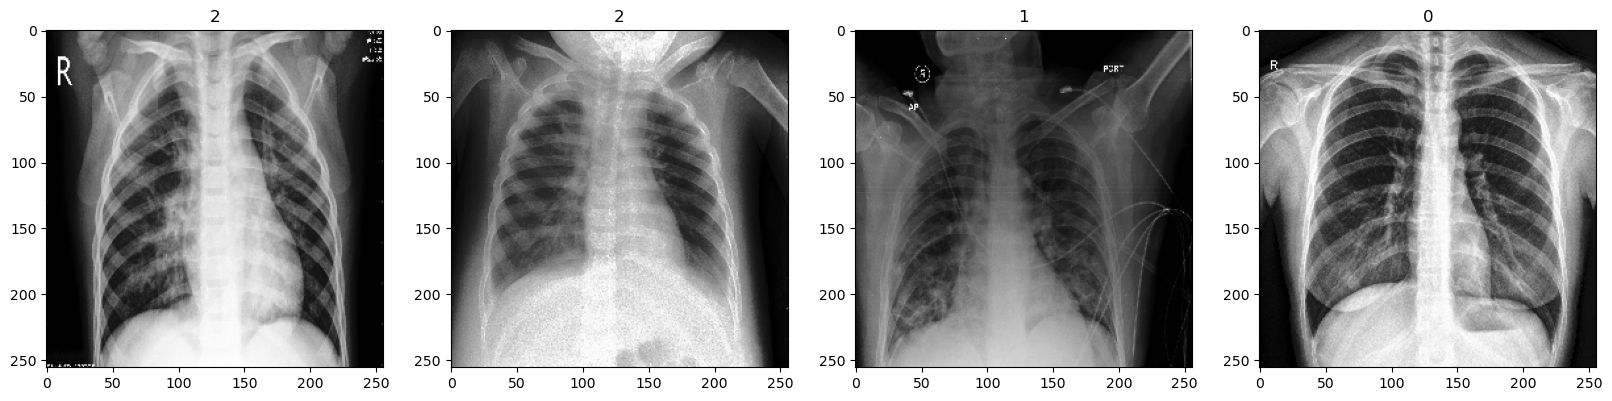

In [8]:
# Visualize the training data
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [9]:
image_size = (48, 48)
batch_size = 10

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "data/train",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 251 files belonging to 3 classes.
Using 201 files for training.
Using 50 files for validation.


### Plot Distribution of Images Across Classes

In [10]:
# Get count of how many files are in each directory

import os, os.path

file_names = ['healthy', 'type 1 disease', 'type 2 disease']

def get_file_count(path, name):
    file_dict = {}

    for x in name:
        for name in os.listdir(f'{path}{x}'):
            file_dict[x] = file_dict.get(x,0)+1
            
    return file_dict

train_data_bar = get_file_count('data/train/',file_names)
test_data_bar = get_file_count('data/test/',file_names)

In [11]:
print(train_data_bar)
print(test_data_bar)

{'healthy': 70, 'type 1 disease': 111, 'type 2 disease': 70}
{'healthy': 20, 'type 1 disease': 26, 'type 2 disease': 20}


<Axes: >

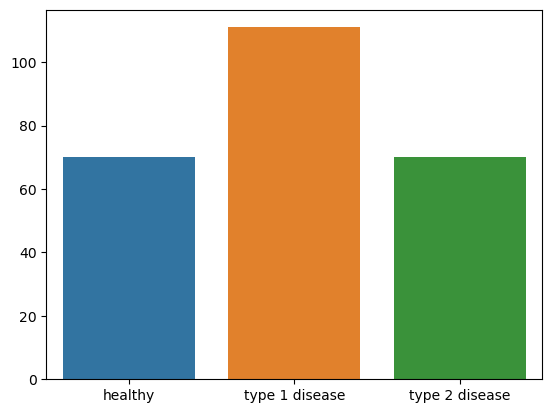

In [12]:
# Get distribution of training data
keys = list(train_data_bar.keys())
vals = [value for value in train_data_bar.values()]
sns.barplot(x=keys, y=vals)

<Axes: >

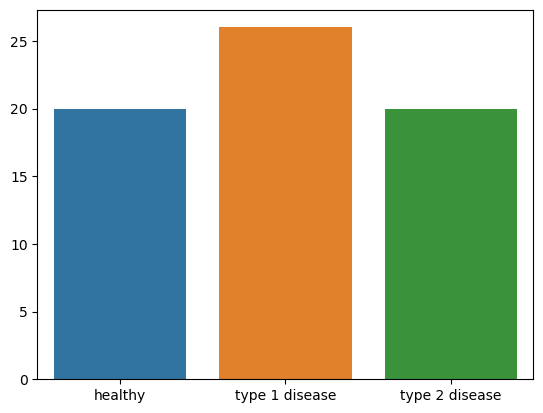

In [13]:
# Get distribution of test data
keys = list(test_data_bar.keys())
vals = [value for value in test_data_bar.values()]
sns.barplot(x=keys, y=vals)

### Data Augmentation for Training Data

In [14]:
from keras.models import Sequential
from keras import layers

data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


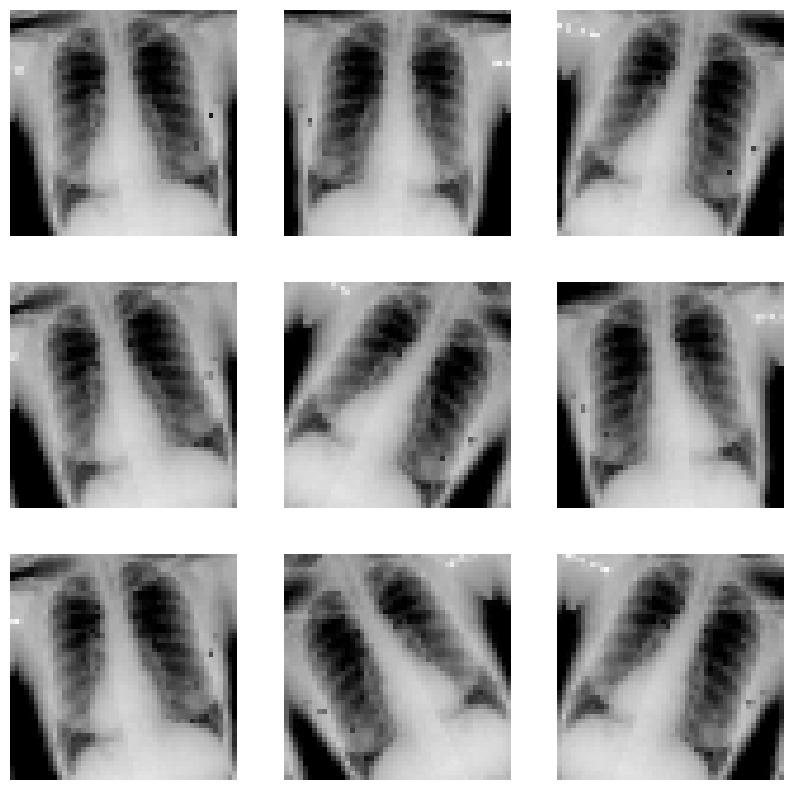

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


### Data Preprocessing

Apply this function within the model training phase

In [16]:
def image_augmentation(training_data):
    augmented_train_ds = training_data.map(
        lambda x, y: (data_augmentation(x, training=True), y))
    return augmented_train_ds

### Building the Model



Add convolutional layers with different filters, max pool layers, dropout layers, and batch normalization layers  

Use Relu as an activation function

Take the loss function as categorical cross-entropy

Take rmsprop as an optimizer

Use early stopping with the patience of two epochs and monitor the validation loss or accuracy

Try with ten numbers epoch

Train the model using a generator and test the accuracy of the test data at every epoch

Plot the training and validation accuracy, and the loss

Observe the precision, recall the F1-score for all classes for both grayscale and color models, and determine if the model’s classes are good


In [17]:
# Model which gets over 97.5% on MNIST dataset (O'Reilly ML)
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization

model = Sequential([
    Convolution2D(32, kernel_size=3, padding="same", activation="relu"),
    Convolution2D(64, kernel_size=3, padding="same", activation="relu"),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.25),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax")])

### Train Model

In [18]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import Precision
epochs = 10

callbacks = [
    keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
]
model.compile(
    optimizer= RMSprop(learning_rate=0.01),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
history_cnn = model.fit(
    image_augmentation(train_ds),
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/10
21/21 [==============================] - 3s 27ms/step - loss: 2718.5305 - accuracy: 0.4229 - val_loss: 1.2212 - val_accuracy: 0.4400
Epoch 2/10
21/21 [==============================] - 1s 19ms/step - loss: 1.3314 - accuracy: 0.4726 - val_loss: 0.7591 - val_accuracy: 0.6200
Epoch 3/10
21/21 [==============================] - 1s 19ms/step - loss: 1.0717 - accuracy: 0.5174 - val_loss: 0.6975 - val_accuracy: 0.7000
Epoch 4/10
21/21 [==============================] - 1s 18ms/step - loss: 1.0752 - accuracy: 0.5124 - val_loss: 0.7655 - val_accuracy: 0.7400
Epoch 5/10
21/21 [==============================] - 1s 20ms/step - loss: 10.3499 - accuracy: 0.5323 - val_loss: 0.7733 - val_accuracy: 0.6800


In [19]:
# model.summary()

### Plotting Accuracy/Loss

In [20]:
# Plotting our loss charts
import matplotlib.pyplot as plt

def plot_accuracy_loss(history, x, x_loss, label1, label2):
    # Use the History object we created to get our saved performance results
    history_dict = history.history

    # Extract the loss and validation losses
    loss_values = history_dict[x]
    val_loss_values = history_dict[x_loss]

    # Get the number of epochs and create an array up to that number using range()
    epochs = range(1, len(loss_values) + 1)

    # Plot line charts for both Validation and Training Loss
    line1 = plt.plot(epochs, val_loss_values, label=label1)
    line2 = plt.plot(epochs, loss_values, label=label2)
    plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
    plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
    plt.xlabel('Epochs') 
    plt.ylabel(x)
    plt.grid(True)
    plt.legend()
    plt.show()

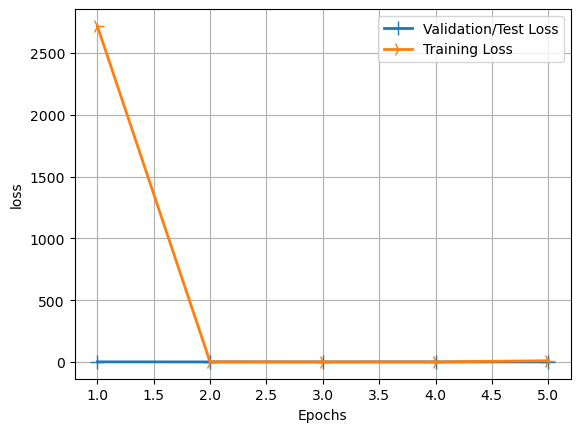

In [21]:
plot_accuracy_loss(history_cnn, 'loss', 'val_loss', 'Validation/Test Loss', 'Training Loss')

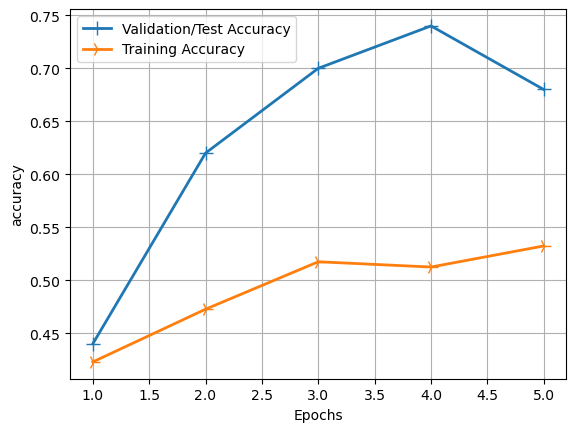

In [22]:
plot_accuracy_loss(history_cnn, 'accuracy', 'val_accuracy', 'Validation/Test Accuracy', 'Training Accuracy')

### Transfer Learning (Mobile Net)



Prepare data for the pre-trained mobile net model, with color mode as RGB

Create an instance of a mobile net pre-trained model 

Add dense layer, dropout layer, batch normalization layer on the pre-trained model

Create a final output layer with a SoftMax activation function

Change the batch size activation function and optimize as rmsprop and observe if the accuracy increases

Take the loss function as categorical cross-entropy

Use early stopping with the patience of two epoch and call back function for preventing overfitting

Try with ten numbers epoch

Train the model using a generator and test the accuracy of the test data at every epoch

 Plot the training and validation accuracy, and the loss

 Observe the precision, recall the F1-score for all classes for both grayscale

and color models, and determine if the model’s classes are good


In [23]:
mobile = keras.applications.mobilenet.MobileNet(classifier_activation='softmax')

In [24]:
# mobile.summary()

#### Color Model

In [25]:
# Preprocess the images
train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory('data/train',
                                                      color_mode='rgb',
                                                      image_size=(224,224),
                                                        batch_size=10,
                                                        seed = 1337,
                                                        validation_split=0.2,
                                                                subset='both')

Found 251 files belonging to 3 classes.
Using 201 files for training.
Using 50 files for validation.


In [26]:
# Making the model
mobile_model_rgb_1 = Sequential([
    mobile,
    Dense(128, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(3, activation="softmax")
                          ])

In [27]:
from tensorflow.keras.optimizers import Adam
# Train Mobile Model
epochs = 10

callbacks = [
    keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
]
mobile_model_rgb_1.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
history_mobile = mobile_model_rgb_1.fit(
    image_augmentation(train_ds),
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/10
21/21 [==============================] - 3s 51ms/step - loss: 1.0772 - accuracy: 0.3980 - val_loss: 1.0963 - val_accuracy: 0.2600
Epoch 2/10
21/21 [==============================] - 1s 34ms/step - loss: 0.9322 - accuracy: 0.5622 - val_loss: 1.0872 - val_accuracy: 0.5000
Epoch 3/10
21/21 [==============================] - 1s 34ms/step - loss: 0.7932 - accuracy: 0.7363 - val_loss: 1.0736 - val_accuracy: 0.6200
Epoch 4/10
21/21 [==============================] - 1s 35ms/step - loss: 0.7028 - accuracy: 0.7313 - val_loss: 1.0552 - val_accuracy: 0.6600
Epoch 5/10
21/21 [==============================] - 1s 38ms/step - loss: 0.5457 - accuracy: 0.8308 - val_loss: 1.0349 - val_accuracy: 0.7400
Epoch 6/10
21/21 [==============================] - 1s 36ms/step - loss: 0.5502 - accuracy: 0.7960 - val_loss: 1.0154 - val_accuracy: 0.8800
Epoch 7/10
21/21 [==============================] - 1s 38ms/step - loss: 0.5569 - accuracy: 0.7562 - val_loss: 1.0045 - val_accuracy: 0.8800
Epoch 8/10
21

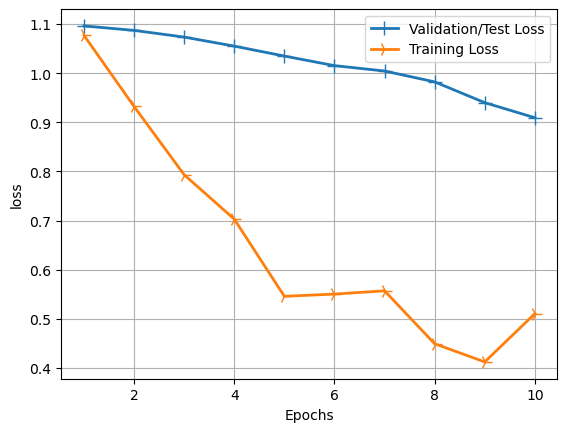

In [28]:
plot_accuracy_loss(history_mobile, 'loss', 'val_loss', 'Validation/Test Loss', 'Training Loss')

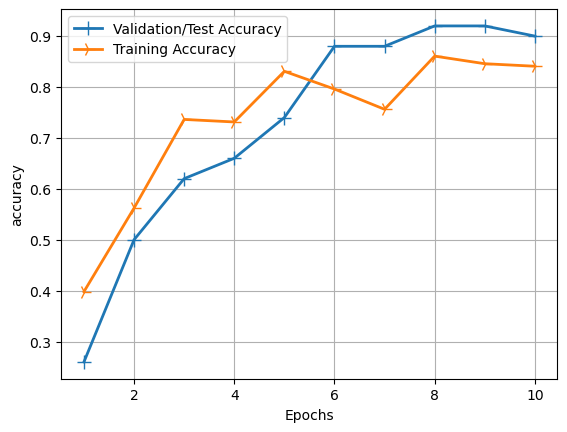

In [29]:
plot_accuracy_loss(history_mobile, 'accuracy', 'val_accuracy', 'Validation/Test Accuracy', 'Training Accuracy')

### Chaging Batch Size and Optimizer

In [30]:
# Preprocess the images
train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory('data/train',
                                                      color_mode='rgb',
                                                      image_size=(224,224),
                                                        batch_size=10,
                                                        seed = 1337,
                                                        validation_split=0.2,
                                                                subset='both')

Found 251 files belonging to 3 classes.
Using 201 files for training.
Using 50 files for validation.


In [31]:
# Making the model
mobile_model_rgb_2 = Sequential([
    mobile,
    Dense(128, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(3, activation="softmax")
                          ])

In [32]:
epochs = 10

callbacks = [
    keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
]
mobile_model_rgb_2.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
history_mobile = mobile_model_rgb_2.fit(
    image_augmentation(train_ds),
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/10
21/21 [==============================] - 4s 62ms/step - loss: 1.0830 - accuracy: 0.5075 - val_loss: 1.0677 - val_accuracy: 0.4800
Epoch 2/10
21/21 [==============================] - 1s 43ms/step - loss: 0.9032 - accuracy: 0.6219 - val_loss: 1.0085 - val_accuracy: 0.5200
Epoch 3/10
21/21 [==============================] - 1s 43ms/step - loss: 0.8690 - accuracy: 0.6020 - val_loss: 0.9971 - val_accuracy: 0.6000
Epoch 4/10
21/21 [==============================] - 1s 39ms/step - loss: 1.0264 - accuracy: 0.5323 - val_loss: 1.0384 - val_accuracy: 0.4800
Epoch 5/10
21/21 [==============================] - 1s 44ms/step - loss: 1.1801 - accuracy: 0.5025 - val_loss: 1.0888 - val_accuracy: 0.4800


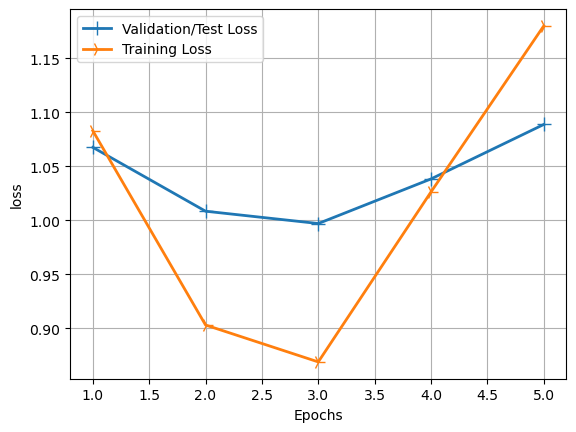

In [33]:
plot_accuracy_loss(history_mobile, 'loss', 'val_loss', 'Validation/Test Loss', 'Training Loss')

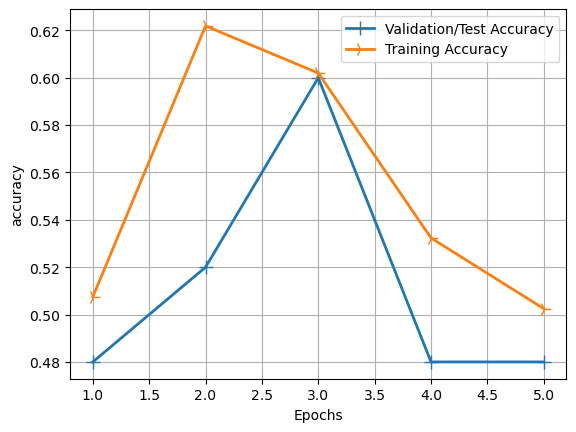

In [34]:
plot_accuracy_loss(history_mobile, 'accuracy', 'val_accuracy', 'Validation/Test Accuracy', 'Training Accuracy')

### Greyscale Model

The pretrained model is trained on RGB pictures and cannot be applied to greyscale images

### Transfer Learning (Densenet121)



Prepare the dataset for the transfer learning algorithm using Densenet121 with the image size as 224x224x3

Freeze the top layers of the pre-trained model

Add a dense layer at the end of the pre-trained model followed by a dropout layer and try various combinations to get an accuracy

Add the final output layer with a SoftMax activation function

Take loss function as categorical cross-entropy

Take Adam as an optimizer

Use early stopping to prevent overfitting

Try with 15 number of epoch and batch size with seven, also try various values to see the impact on results

Train the model using the generator and test the accuracy of the test data at every epoch 

 Plot the training and validation accuracy, and the loss

Observe the precision, recall the F1-score for all classes for both grayscale

and color models, and determine if the model’s classes are good

In [35]:
dense_model = keras.applications.DenseNet121(classifier_activation='softmax')

In [36]:
# dense_model.summary()

Use the same datasets as above for training this model

Freeze Layers

In [37]:
dense_model.trainable = False

In [38]:
inputs = keras.Input(shape=(224,224, 3))
x = dense_model(inputs, training=False)
x = Dropout(0.5)(x)
outputs = keras.layers.Dense(3)(x)
dense_model_add = keras.Model(inputs, outputs)


In [39]:
# Train Dense Model
epochs = 10

callbacks = [
    keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
]
dense_model_add.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
history_dense = dense_model_add.fit(
    image_augmentation(train_ds),
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/10
21/21 [==============================] - 6s 105ms/step - loss: 5.1430 - accuracy: 0.3383 - val_loss: 3.2213 - val_accuracy: 0.4200
Epoch 2/10
21/21 [==============================] - 1s 48ms/step - loss: 4.7252 - accuracy: 0.3831 - val_loss: 3.2270 - val_accuracy: 0.4000
Epoch 3/10
21/21 [==============================] - 1s 53ms/step - loss: 3.9796 - accuracy: 0.3582 - val_loss: 3.3917 - val_accuracy: 0.3800


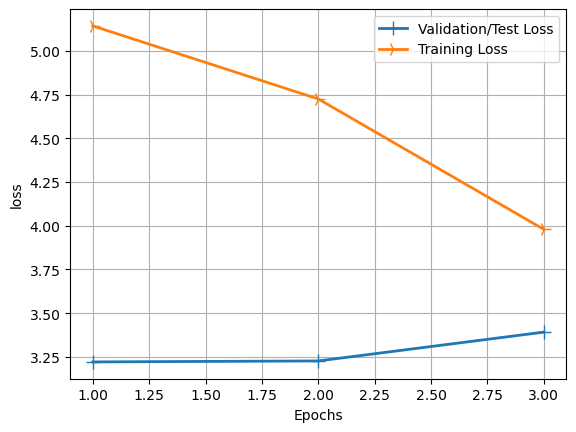

In [40]:
plot_accuracy_loss(history_dense, 'loss', 'val_loss', 'Validation/Test Loss', 'Training Loss')

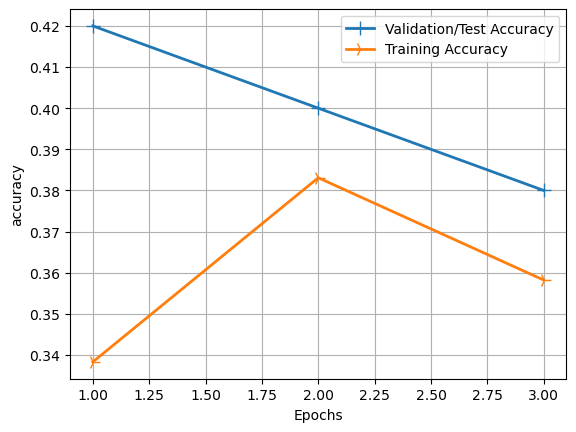

In [41]:
plot_accuracy_loss(history_dense, 'accuracy', 'val_accuracy', 'Validation/Test Accuracy', 'Training Accuracy')

### Changing Batch Size, Epoch, Optimizer, Learning Rate

In [42]:
# Preprocess the images
train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory('data/train',
                                                      color_mode='rgb',
                                                      image_size=(224,224),
                                                        batch_size=7,
                                                        seed = 1337,
                                                        validation_split=0.2,
                                                                subset='both')

Found 251 files belonging to 3 classes.
Using 201 files for training.
Using 50 files for validation.


In [43]:
# Train Dense Model
epochs = 15

callbacks = [
    keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
]
dense_model_add.compile(
    optimizer=Adam(learning_rate=0.01),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
history_dense = dense_model_add.fit(
    image_augmentation(train_ds),
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/15
29/29 [==============================] - 6s 82ms/step - loss: 2.4538 - accuracy: 0.3881 - val_loss: 1.0986 - val_accuracy: 0.4800
Epoch 2/15
29/29 [==============================] - 1s 39ms/step - loss: 1.2076 - accuracy: 0.4478 - val_loss: 1.0986 - val_accuracy: 0.4600
Epoch 3/15
29/29 [==============================] - 1s 44ms/step - loss: 1.0549 - accuracy: 0.5373 - val_loss: 1.0986 - val_accuracy: 0.4600


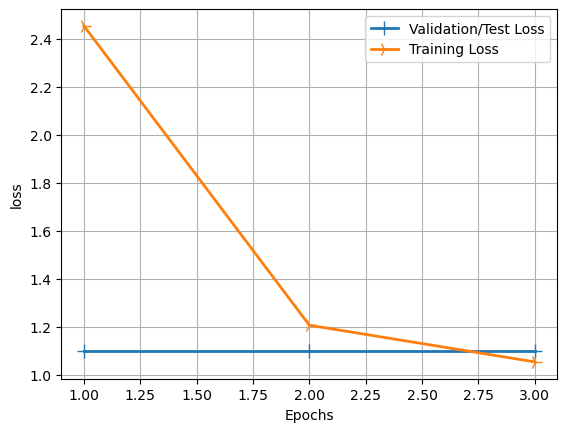

In [44]:
plot_accuracy_loss(history_dense, 'loss', 'val_loss', 'Validation/Test Loss', 'Training Loss')

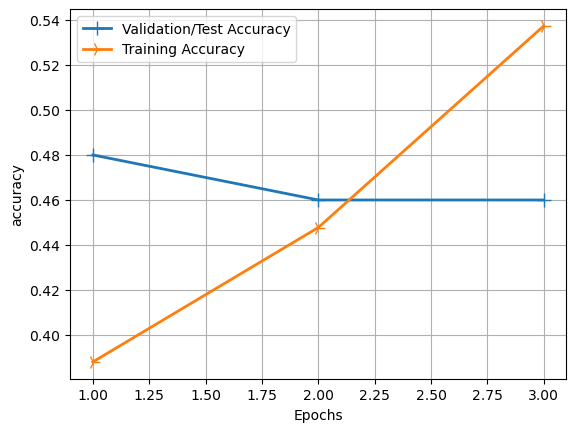

In [45]:
plot_accuracy_loss(history_dense, 'accuracy', 'val_accuracy', 'Validation/Test Accuracy', 'Training Accuracy')

### Grayscale DenseNet121

The pretrained model is trained on RGB pictures and cannot be applied to greyscale images

### Compare models on Test Data

#### CNN Model Evaluation (No Transfer Learning

In [46]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "data/test",
    image_size=(48,48),
)

Found 66 files belonging to 3 classes.


In [47]:
model.evaluate(test_ds)

3/3 [==============================] - 0s 11ms/step - loss: 1.5955 - accuracy: 0.3333


[1.5954846143722534, 0.3333333432674408]

#### Mobile Net Transfer Learning Model Evaluation

In [48]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "data/test",
     color_mode='rgb',
    image_size=(224,224),
)

Found 66 files belonging to 3 classes.


In [49]:
mobile_model_rgb_1.evaluate(test_ds)

3/3 [==============================] - 0s 10ms/step - loss: 1.1034 - accuracy: 0.5758


[1.1033506393432617, 0.5757575631141663]

#### DenseNet121 Transfer Learning Model Evaluation

In [50]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "data/test",
    image_size=(224,224),
)

Found 66 files belonging to 3 classes.


In [51]:
dense_model_add.evaluate(test_ds)

3/3 [==============================] - 0s 40ms/step - loss: 1.0986 - accuracy: 0.3030


[1.0986123085021973, 0.3030303120613098]

### Final Step

Overall the model which performed the best on the test data was the mobile_model